# Analyse qualitative

Uniquement sur les données où les référentiels d'Île-de-France ont été intégrés

In [1]:
import pandas as pd
import os
import json
from shapely.geometry import Point
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)



In [2]:
#in_folder = "audits/2018_04/data/"
#out_folder = "audits/2018_04/images/"
in_folder = "../data/"
out_folder = "/tmp/"

## Mapping des routepoints (reflex, coddifligne, terminus)

Chargement des routepoints OSM et GTFS

In [3]:
quali_osm_routepoints = pd.read_csv(os.path.join(in_folder, "osm_routepoints_for_matching.csv"), dtype=str)
for c in quali_osm_routepoints.columns:
    new_col = "osm_" + c
    quali_osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv(os.path.join(in_folder, "opendata_routepoints.csv"), dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
print("On a {:d} routepoints dans OSM et {:d} routepoints dans le GTFS".format(quali_osm_routepoints.shape[0], gtfs_routepoints.shape[0]))



On a 11595 routepoints dans OSM et 103087 routepoints dans le GTFS


In [4]:
quali_gtfs_routepoints = gtfs_routepoints.copy().fillna("")
quali_gtfs_routepoints = quali_gtfs_routepoints[quali_gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
yofix_routepoints = quali_gtfs_routepoints.merge(
                    quali_osm_routepoints, how='outer', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
yofix_routepoints.fillna("", inplace=True)

tt = yofix_routepoints[yofix_routepoints['gtfs_route_id'] == '']
tt[["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line", "osm_stop_id", "gtfs_route_id"]]
# détecter au préalable les pb de codes de lignes ?



,osm_osm:ref:FR:STIF,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_stop_id,gtfs_route_id
104916,38508,014014030:30D,StopPoint:Node:5320764715,
104917,423960,014014030:30D,StopPoint:Node:5326079506,
104918,38519,014014030:30D,StopPoint:Node:5326079505,
104919,37968,014014030:30D,StopPoint:Node:5320764709,
104920,38698,014014030:30D,StopPoint:Node:837540002,
104921,38670,014014030:30D,StopPoint:Node:837539998,
104922,38634,014014030:30D,StopPoint:Node:837539990,
104923,415750,014014030:30D,StopPoint:Node:837540004,
104924,38442,014014030:30D,StopPoint:Node:5320764711,
104925,38837,014014030:30D,StopPoint:Node:372739907,


On fusionne les routepoints par code REFLEX, Codifligne et on calcule la correspondance de terminus

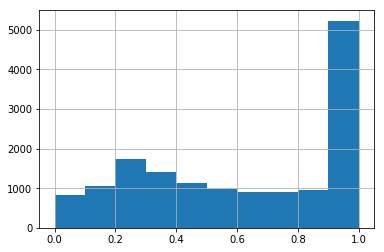

In [5]:
quali_gtfs_routepoints = gtfs_routepoints.copy().fillna("")
quali_gtfs_routepoints = quali_gtfs_routepoints[quali_gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
quali_routepoints = quali_gtfs_routepoints.merge(
                    quali_osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
quali_routepoints.fillna("", inplace=True)

def compute_similarity_lower(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
quali_routepoints['destination_confidence'] = quali_routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
quali_routepoints['destination_confidence'].hist()


**Pour la suite, on ne conserve que les routepoints qui matchent à 60% et plus**

In [6]:
quali_routepoints_filtered = quali_routepoints[quali_routepoints['destination_confidence'] >= 0.6].copy()
"{:d} routepoints matchant à plus de 60%".format(quali_routepoints_filtered.shape[0])

'8060 routepoints matchant à plus de 60%'

In [7]:
tt = len(quali_routepoints_filtered) * 100.0 / len(gtfs_routepoints)
"Pourcentage de routepoints qu'on considère pour la suite : {}".format(tt)

"Pourcentage de routepoints qu'on considère pour la suite : 7.818638625626898"

NB : le matching sur les terminus est loin d'être parfait. Pour de meilleurs résultats, il faudrait :
* soit un référentiel officiel des parcours (qui pourrait être importé dans les données OSM)
* soit établir un tableau de correspondance entre les terminus

(cf quelques contrexemples ci-dessous)

In [8]:
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Massy', 'Gare RER Massy Palaiseau').ratio() #0.34
difflib.SequenceMatcher(None, 'Gare de La Verrière', 'LA VERRIERE NOCTILIEN'.lower()).ratio() #0.4

0.4

In [9]:
print('Nombre total de parcours en utilisant les destinations pour les séparer des lignes :')
len(gtfs_routepoints.groupby(['gtfs_route_id','gtfs_dest_name']).size())

Nombre total de parcours en utilisant les destinations pour les séparer des lignes :


5638

## Mesures qualitatives

## Analyse des codes de ligne

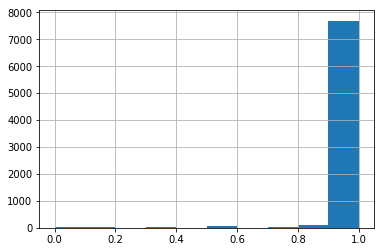

In [10]:
# différences sur les codes de ligne
quali_routepoints_filtered['line_code_confidence'] = quali_routepoints_filtered[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["line_code_confidence_rounded"] = quali_routepoints_filtered["line_code_confidence"].round(1) * 100

# quali_routepoints_and_line_volume
quali_routepoints_filtered['line_code_confidence'].hist()

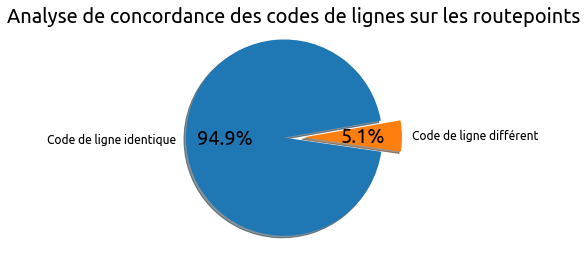

In [11]:
routepoints_count_total = quali_routepoints_filtered.shape[0]
routepoints_count_with_perfect_line_mapping = quali_routepoints_filtered[quali_routepoints_filtered["line_code_confidence_rounded"] == 100].shape[0]
routepoints_count_with_different_line_mapping = routepoints_count_total - routepoints_count_with_perfect_line_mapping
labels = 'Code de ligne identique', 'Code de ligne différent'


sizes = [routepoints_count_with_perfect_line_mapping/routepoints_count_total * 100, 
         routepoints_count_with_different_line_mapping/routepoints_count_total * 100]
explode = (0, 0.2)

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
fig1, ax1 = plt.subplots()
ax1.set_title('Analyse de concordance des codes de lignes sur les routepoints')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig(os.path.join(out_folder, '11_routepoints_line_code_mapping_pie.png'), bbox_inches='tight')

In [12]:
routepoints_with_different_line_mapping = quali_routepoints_filtered[quali_routepoints_filtered["line_code_confidence_rounded"] < 100]


lines_with_different_line_mapping = pd.DataFrame(routepoints_with_different_line_mapping.groupby(['gtfs_route_short_name', 'osm_code']).size()).reset_index()
print("Il y a {:d} lignes qui ne correspondent pas sur un total de {:d}".format(
    lines_with_different_line_mapping.shape[0],
    pd.DataFrame(quali_routepoints_filtered.groupby(['gtfs_route_short_name', 'osm_code']).size()).shape[0]
))
lines_with_different_line_mapping.head()


Il y a 28 lignes qui ne correspondent pas sur un total de 335


,gtfs_route_short_name,osm_code,0
0,49,49a,26
1,49,49b,32
2,49,49c,37
3,AS-SURE,AS (544),4
4,BIEVRES,513,1


### Analyse des différence sur les noms des arrêts

In [13]:
quali_routepoints_filtered['name_confidence'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["name_confidence_rounded"] = quali_routepoints_filtered["name_confidence"].round(1) * 100
quali_routepoints_filtered['name_confidence_lower'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
quali_routepoints_filtered["name_confidence_lower_rounded"] = quali_routepoints_filtered["name_confidence_lower"].round(1) * 100


In [14]:
routepoints_count = quali_routepoints_filtered.shape[0]
borne_identique = 0.9
borne_proche = 0.7
identiques = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] >= borne_identique].shape[0]
proches = quali_routepoints_filtered[
    (quali_routepoints_filtered["name_confidence"] < borne_identique) & 
    (quali_routepoints_filtered["name_confidence"] >= borne_proche)].shape[0]
differents = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence"] < borne_proche].shape[0]

identiques_lower = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence_lower'] >= borne_identique].shape[0]
proches_lower = quali_routepoints_filtered[
    (quali_routepoints_filtered["name_confidence_lower"] < borne_identique) & 
    (quali_routepoints_filtered["name_confidence_lower"] >= borne_proche)].shape[0]
differents_lower = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence_lower"] < borne_proche].shape[0]

#quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] >= borne_proche].sort_values("name_confidence")

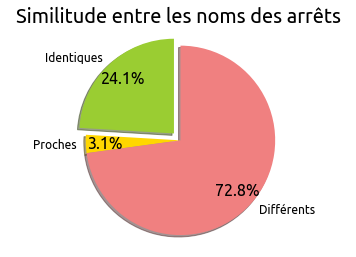

In [15]:
sizes = [identiques/routepoints_count * 100, 
         proches/routepoints_count * 100,
         differents/routepoints_count * 100]
sizes_lower = [identiques_lower/routepoints_count * 100, 
         proches_lower/routepoints_count * 100,
         differents_lower/routepoints_count * 100]
explode = (0.1, 0, 0)
colors = ['yellowgreen', 'gold', 'lightcoral']
labels = 'Identiques', 'Proches', 'Différents'

fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title('Similitude entre les noms des arrêts')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=colors,
        shadow=True, startangle=90, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(out_folder,'12_routepoints_name_mapping_pie.png'), bbox_inches='tight')

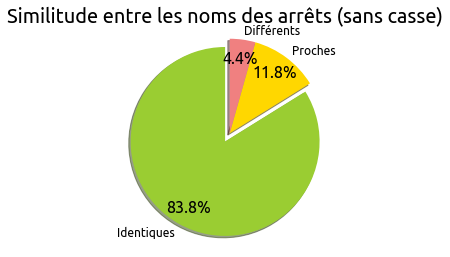

In [16]:
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title('Similitude entre les noms des arrêts (sans casse)')
ax1.pie(sizes_lower, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=colors,
        shadow=True, startangle=90, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(out_folder,'12_routepoints_name_mapping_pie_lower.png'), bbox_inches='tight')

Visualisation de quelques cas les plus différents (avec majuscules)

In [17]:
quali_routepoints_filtered_ = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] < 0.5]
quali_routepoints_filtered_ = quali_routepoints_filtered_[['gtfs_stop_name', 'osm_name']]
grouped = quali_routepoints_filtered_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
quali_unique_df = quali_routepoints_filtered_.reindex(index)
quali_unique_df.head()

,gtfs_stop_name,osm_name
6489,PONT D'AUSTERLITZ - QUAI DE LA RAPEE,Pont d'Austerlitz - Quai de la Rapée
8298,PUVIS DE CHAVANNES,Puvis de Chavannes
6392,ARTS ET METIERS,Arts et Métiers
10472,ESCADRILLE NORMANDIE-NIEMEN - PAUL VAILLANT-CO...,Escadrille Normandie-Niémen - Paul Vaillant-Co...
11952,WATT,Watt


VIsualisation des cas les plus différents (sans majuscules)

In [18]:
quali_routepoints_filtered_ = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence_lower'] < 0.5]
quali_routepoints_filtered_ = quali_routepoints_filtered_[['gtfs_stop_name', 'osm_name']]
grouped = quali_routepoints_filtered_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
quali_unique_df = quali_routepoints_filtered_.reindex(index)
quali_unique_df.head(10)

,gtfs_stop_name,osm_name
6340,Mairie,Mairie de Saint-Cyr-l'École
11384,STADE DE CHATILLON,Stade
14889,Eglise Saint Nicolas,Église du Bourget
3164,POSTE,Collégien - Poste
2970,GARE DE MARNE LA VALLEE CHESSY,Chessy Gares
953,Mairie de Goussainville,Mairie
10773,FRANKLIN,Montgolfier
20,Gare de Torcy,Torcy RER
14884,Mairie,Mairie de Livry-Gargan
9118,BRANCION - MORILLONS,Morillons - Brancion


### Analyse des distances 

In [19]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
quali_routepoints_filtered['distance'] = quali_routepoints_filtered.apply(compute_distance, axis=1)
#uali_routepoints_filtered['distance'].hist()

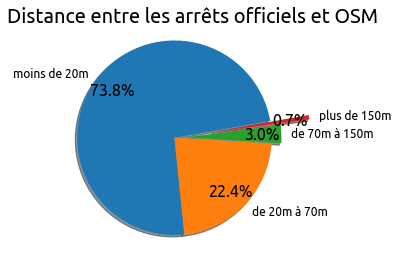

In [20]:
routepoints_count = quali_routepoints_filtered.shape[0]
labels = 'moins de 20m', 'de 20m à 70m', 'de 70m à 150m', 'plus de 150m'
count_moins_20 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] < 20].shape[0]
count_20_70 = quali_routepoints_filtered[(quali_routepoints_filtered["distance"] >= 20) & (quali_routepoints_filtered["distance"] < 70)].shape[0]
count_70_150 = quali_routepoints_filtered[(quali_routepoints_filtered["distance"] >= 70) & (quali_routepoints_filtered["distance"] < 150)].shape[0]
count_plus_150 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] >= 150].shape[0]

sizes = [count_moins_20/routepoints_count * 100, 
         count_20_70/routepoints_count * 100,
         count_70_150/routepoints_count * 100,
         count_plus_150/routepoints_count * 100]
explode = (0, 0, 0.1, 0.4)

fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title('Distance entre les arrêts officiels et OSM')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(out_folder,'14_routepoints_distance_pie_V2.png'), bbox_inches='tight')

In [21]:
print("Distance max : {:f}".format(quali_routepoints_filtered['distance'].max()))
print("Distance moyenne : {:f}".format(quali_routepoints_filtered['distance'].mean()))
print("Distance médiane : {:f}".format(quali_routepoints_filtered['distance'].median()))


Distance max : 777.634409
Distance moyenne : 18.883215
Distance médiane : 9.529780


In [22]:
routepoints_bad_position = quali_routepoints_filtered[quali_routepoints_filtered['distance'] > 70].copy()
print("Nombre de routepoints à plus de 70m : {:d}".format(len(routepoints_bad_position)))

Nombre de routepoints à plus de 70m : 301


In [23]:
print("Nombre de stoppoints du GTFS à plus de 70m : {:d}".format(
    len(routepoints_bad_position.groupby(['gtfs_stop_id'])[["distance"]].count()))
)

Nombre de stoppoints du GTFS à plus de 70m : 210
